## Import Dependencies

In [24]:
!pip install osmnx networkx

In [25]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## Get Natal multigraph and tourist points of interests (POIs)

In [27]:
def to_undirected_multigraph(G):
    """
    Converte um MultiDiGraph direcionado em um MultiGraph não-direcionado,
    preservando atributos dos nós e arestas.
    """
    H = nx.MultiGraph()
    # Copiar nós e seus atributos
    for n, data in G.nodes(data=True):
        H.add_node(n, **data)

    # Copiar arestas e seus atributos, sem direcionamento
    for u, v, data in G.edges(data=True):
        # Em um MultiGraph, se já existir uma aresta u-v, esta será adicionada como mais uma aresta paralela
        H.add_edge(u, v, **data)

    H.graph.update(G.graph)
    return H

# Get Natal multigraph
city = "Natal, Rio Grande do Norte, Brazil"
G = ox.graph_from_place(city, network_type='drive')

graph = to_undirected_multigraph(G)

In [32]:
pois = [
    {"name": "Arena das Dunas", "color": "orange", "coords": (-5.831111, -35.205833)},
    {"name": "Parque das Dunas", "color": "lime", "coords": (-5.837558, -35.194720)},
    {"name": "Forte dos Reis Magos", "color": "green", "coords": (-5.756266898447098, -35.19497968971633)},
    {"name": "Parque da Cidade", "color": "yellow", "coords": (-5.850235280916188, -35.226226951926)},
    {"name": "Museu Câmara Cascudo", "color": "cyan", "coords": (-5.803170160249714, -35.20119414420729)},
    {"name": "Morro do Careca", "color": "blue", "coords": (-5.883684255366649, -35.16444783802863)},
]

for poi in pois:
    lat, lon = poi["coords"]
    node = ox.distance.nearest_nodes(graph, X=[lon], Y=[lat])[0]
    poi["node"] = node

## Generate complete graph with smaller route between POIs

In [29]:
nodes = [poi["node"] for poi in pois]
pois_graph = nx.Graph()
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        route = nx.shortest_path(graph, nodes[i], nodes[j], weight="length")
        route_length = 0
        for k in range(len(route) - 1):
            route_length += graph[route[k]][route[k + 1]][0]["length"]
        pois_graph.add_edge(nodes[i], nodes[j], weight=route_length)

## Calculate MST

In [30]:
mst_edges = list(nx.minimum_spanning_edges(pois_graph, data=True))
total_mst_length = sum([d["weight"] for (u, v, d) in mst_edges])
print("Comprimento total do MST entre os POIs selecionados:", total_mst_length, "metros")

Comprimento total do MST entre os POIs selecionados: 21970.787398641325 metros


## Plot graph

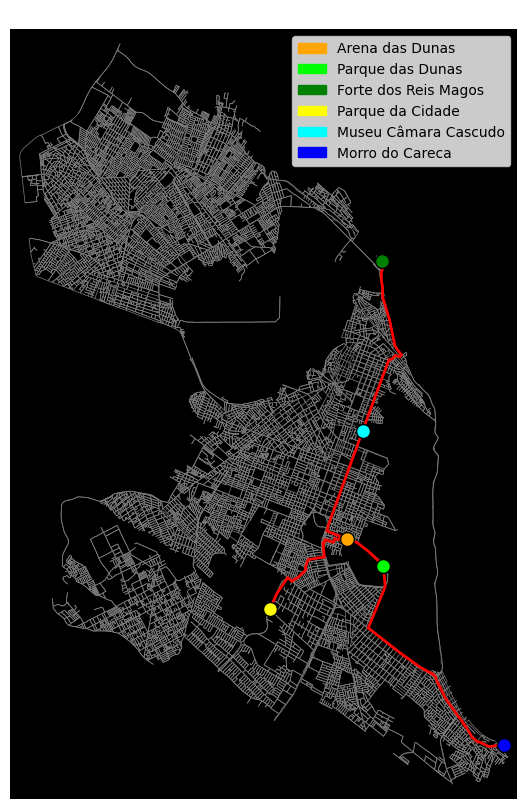

In [33]:
fig, ax = ox.plot_graph(
    graph,
    show=False,
    close=False,
    edge_color="gray",
    edge_linewidth=0.5,
    node_size=0,
    bgcolor="black",
    figsize=(10, 10),
)

# Destacar as rotas do MST em vermelho
for u, v, data in mst_edges:
    route = nx.shortest_path(graph, u, v, weight="length")
    x = [graph.nodes[n]["x"] for n in route]
    y = [graph.nodes[n]["y"] for n in route]
    ax.plot(x, y, color="red", linewidth=2, zorder=4)

# Adicionar os POIs ao gráfico e criar a legenda
legend_handles = []
for poi in pois:
    node = poi["node"]
    poi_x = graph.nodes[node]["x"]
    poi_y = graph.nodes[node]["y"]
    ax.scatter(poi_x, poi_y, c=poi["color"], s=100, zorder=5, edgecolor="black", label=poi["name"])
    legend_handles.append(mpatches.Patch(color=poi["color"], label=poi["name"]))

# Adicionar a legenda
ax.legend(handles=legend_handles, loc="best", fontsize=10)

plt.title("MST entre Pontos Turísticos de Natal", fontsize=10, color="white")
plt.show()